In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [2]:
import pandas as pd
from functools import reduce

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )

  for gc_window_size in [
    1000, 
    10000, 
    100000,
    1000000,
  ]:
    df_temp = pd.read_csv(
      f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{gc_window_size}.bed', 
      sep='\t', 
    )
    df_temp = df_temp[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
    df_temp = df_temp.rename(columns={
      'chen_chrom': 'chrom', 
      'chen_start': 'start', 
      'chen_end': 'end',
      'window_GC_content': f'GC_content_{gc_window_size}bp'
    })
    df1 = pd.merge(df1, df_temp, on=['chrom', 'start', 'end'], how='inner')

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df2 = df2[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df2 = df2.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,...,B0_M3starHMT6.EUR,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True
1019147,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False
1019148,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False
1019149,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,...,0.135944,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False


## Chen predictions are enriched in high-GC-content windows, but enhancers are not, suggesting that the model is “biased”

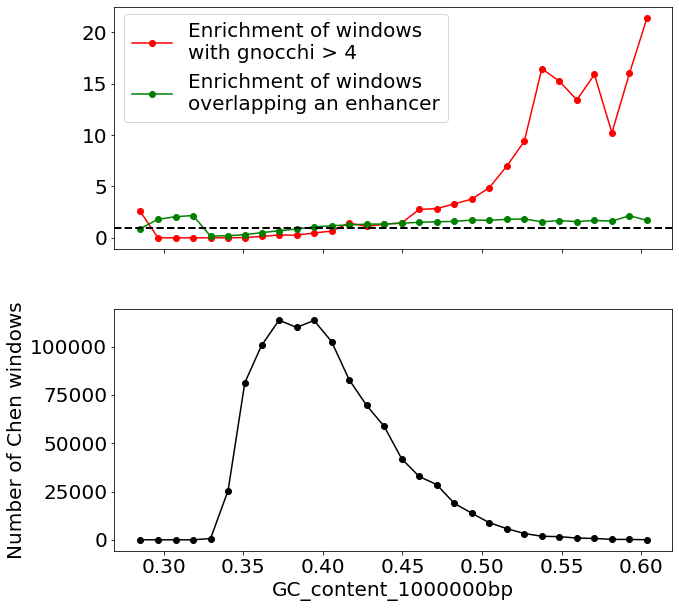

In [5]:
import matplotlib.pyplot as plt

def plot_enrichment_of_windows(df, feature, gnocchi_threshold, sign, number_bins=30, ylim=None): 
  df = df.copy() 

  df[f'{feature}_bin'] = pd.cut(df[feature], bins=number_bins)
  
  total_counts = df[f'{feature}_bin'].value_counts().sort_index()
  total_frac = total_counts/total_counts.sum()

  if sign == '>':
    gnocchi_calls = df[df['gnocchi'] > gnocchi_threshold]
  elif sign == '<': 
    gnocchi_calls = df[df['gnocchi'] < gnocchi_threshold]
  gnocchi_counts = gnocchi_calls[f'{feature}_bin'].value_counts().sort_index()
  gnocchi_frac = gnocchi_counts / gnocchi_counts.sum() 

  enhancer_counts = df[df['window overlaps enhancer'] == True][f'{feature}_bin'].value_counts().sort_index()
  enhancer_frac = enhancer_counts / enhancer_counts.sum() 

  gnocchi_enrichment = gnocchi_frac / total_frac
  enhancer_enrichment = enhancer_frac / total_frac
  
  total_counts.index = total_counts.index.map(lambda x: x.mid)
  gnocchi_enrichment.index = gnocchi_enrichment.index.map(lambda x: x.mid)
  enhancer_enrichment.index = enhancer_enrichment.index.map(lambda x: x.mid)

  plt.rcParams.update({'font.size': 20})

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  axs[0].plot(gnocchi_enrichment.index, gnocchi_enrichment, 'o-', color='red', label=f'Enrichment of windows\nwith gnocchi {sign} {gnocchi_threshold}')
  axs[0].plot(enhancer_enrichment.index, enhancer_enrichment, 'o-', color='green', label=f'Enrichment of windows\noverlapping an enhancer')
  axs[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
  axs[0].set_ylim(ylim)
  axs[0].legend(bbox_to_anchor=(0, 0.75), loc='center left')

  axs[1].plot(total_counts.index, total_counts, 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')
  axs[1].set_xlabel(feature)

plot_enrichment_of_windows(WINDOWS, gnocchi_threshold=4, sign='>', feature='GC_content_1000000bp')